In [120]:
## Libraries
import glob
from multiprocessing import cpu_count
import os
import random
import sys

## 3rd party
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
import torch
from torch.utils.data import DataLoader

_path = ".."
if _path not in sys.path:
    sys.path.append(_path)
from lib.dataset import TextArtDataLoader, AlignCollate, ImageBatchSampler
from lib.config import Config
# from lib.preprocess import (pad_image, crop_edges_lr, )

%reload_ext autoreload
%autoreload 2

In [105]:
BATCH_SIZE = 4
# N_WORKERS = cpu_count() - 1
N_WORKERS = 0
CONFIG = Config()

In [106]:
train_dataset = TextArtDataLoader(CONFIG, mode='train')
val_dataset = TextArtDataLoader(CONFIG, mode='val')
test_dataset = TextArtDataLoader(CONFIG, mode='test')

train_align_collate = AlignCollate(CONFIG, 'train')
val_align_collate = AlignCollate(CONFIG, 'val')

train_batch_sampler = ImageBatchSampler(CONFIG, mode='train')
val_batch_sampler = ImageBatchSampler(CONFIG, mode='val')

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=N_WORKERS,
                          pin_memory=True,
                          collate_fn=train_align_collate,
                          sampler=train_batch_sampler,
                         )
val_loader = DataLoader(val_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=N_WORKERS,
                          pin_memory=True,
                          collate_fn=val_align_collate,
                          sampler=val_batch_sampler
                         )
test_loader = DataLoader(test_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=N_WORKERS,
                          pin_memory=True,
                          collate_fn=None,
                         )

IMAGE: (64, 64, 3)
WV: torch.Size([4, 8, 1536])
Fake WV: torch.Size([4, 8, 1536])
WVs
design/1.000 symbolism/1.000 petersburg/1.000 deco/1.000 word/1.000 pop/1.000 costume/1.000 folly/1.000 
portrait/1.000 realism/1.000 male/1.000 mole/1.000 nude/1.000 handwork/1.000 street/1.000 realism/1.000 
genre/1.000 painting/1.000 expressionism/1.000 disease/1.000 treatment/1.000 koln/1.000 tradition/1.000 muralism/1.000 
design/1.000 surrealism/1.000 manga/1.000 render/1.000 vado/1.000 base/1.000 poland/1.000 tradition/1.000 

Fake WVs
michaud/1.000 digital/1.000 anime/1.000 painting/1.000 aesthetic/1.000 hague/1.000 la/1.000 haag/1.000 
woman/1.000 anime/1.000 fantasy/1.000 anime/1.000 fantasy/1.000 anime/1.000 manga/1.000 digital/1.000 
draw/1.000 anthro/1.000 woman/1.000 azul/1.000 azul/1.000 piccolo/1.000 anthro/1.000 fan/1.000 
freddy/1.000 anime/1.000 croisade/1.000 '/1.000 michaud/1.000 romanticism/1.000 azul/1.000 fan/1.000 


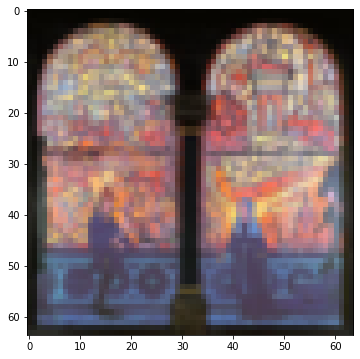

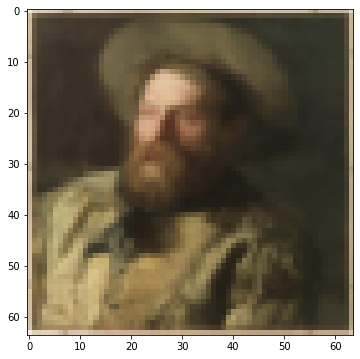

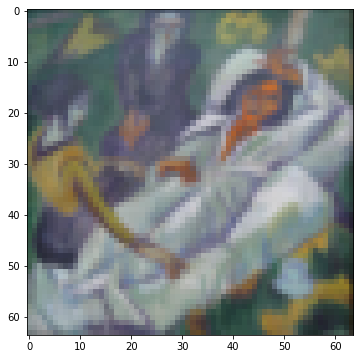

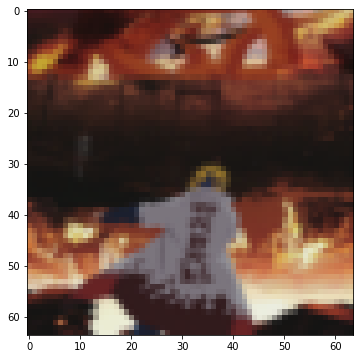

In [107]:
inv_normalize = InvNormalize(CONFIG.MEAN, CONFIG.STD)
for i, (images, wv_tensor, fake_wv_tensor) in enumerate(train_loader):
    print("IMAGE:", image.shape)
    print("WV:", wv_tensor.shape)
    print("Fake WV:", fake_wv_tensor.shape)
    
    print("WVs")
    for wvs in wv_tensor:
        for wv in wvs:
            wv = np.array(wv)
            word, prob = train_loader.dataset.word2vec_model.wv.similar_by_vector(wv)[0]
            print("{}/{:.3f}".format(word, prob), end=' ')
        print()
    
    print("\nFake WVs")
    for fake_wvs in fake_wv_tensor:
        for fake_wv in fake_wvs:
            fake_wv = np.array(fake_wv)
            fake_word, prob = train_loader.dataset.word2vec_model.wv.similar_by_vector(fake_wv)[0]
            print("{}/{:.3f}".format(fake_word, prob), end=' ')
        print()
    
    for image in images:
        image = inv_normalize(image)
        image = np.array(image)
        image = image.transpose(1, 2, 0)
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.show()
    break

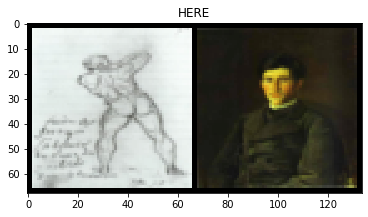

In [48]:
grid = make_grid(images, nrow=2).permute(1, 2, 0)
plt.title("HERE")
plt.imshow(grid)

In [128]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

In [280]:
images_bag = []
for i, (fake_image, real_wvs) in enumerate(zip(images, wv_tensor)):
    words = []
    for real_wv in real_wvs:
        real_wv = np.array(real_wv)
        word, prob = train_dataset.word2vec_model.wv.similar_by_vector(real_wv)[0]
        words.append(word)

    fake_image = np.array(fake_image).transpose(1, 2, 0)
    word_image = words2image(words)
    
    images_bag.extend([word_image, fake_image])
    
images_bag = np.array(images_bag)

In [299]:
grid_pil = Image.fromarray(np.array(grid * 255, dtype=np.uint8))

In [302]:
type(grid_pil)

PIL.Image.Image

In [290]:
torch.save(grid, "asas")

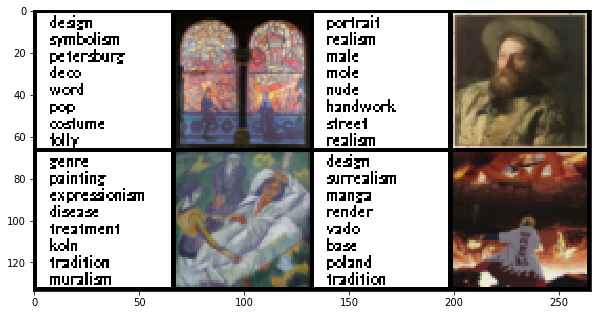

In [286]:
grid = make_grid(torch.Tensor(images_bag.transpose(0, 3, 1, 2)), nrow=4).permute(1, 2, 0)
plt.figure(figsize=(10, 10))
plt.imshow(grid)

In [219]:
from torchvision.utils import make_grid
make_grid(torch.Tensor(images_bag))

TypeError: not a sequence

In [9]:
class InvNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [ ]:
mod = train_dataset.word2vec_model

In [ ]:
mod.wv.similar_by_word('cat', topn=None).shape

In [271]:
from PIL import Image, ImageDraw, ImageFont
def words2image(text_list, image_shapes=(64, 64)):
    w, h = image_shapes

    img = Image.fromarray(np.ones(image_shapes))
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("Lato-Medium.ttf", 7)
    
    x = int(w * 0.1)
    y0 = int(h * 0.01)
    for i, text in enumerate(text_list):
        y = i * len(text_list) + y0
        draw.text((x, y), text, 0, font=font)

    return np.array(img.convert('RGB'))

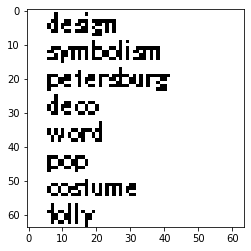

In [215]:
plt.imshow(words2image(words), cmap='gray')

In [269]:
text_list = words
image_shapes = (64, 64)
w, h = image_shapes

img = Image.fromarray(np.ones(image_shapes))
draw = ImageDraw.Draw(img)
font = ImageFont.truetype("Lato-Medium.ttf", 7)

x = int(w * 0.1)
y0 = int(h * 0.01)
for i, text in enumerate(text_list):
    y = i * len(text_list) + y0
    draw.text((x, y), text, 0, font=font)
    
img = img.convert('RGB')

In [270]:
np.array(img).shape

(64, 64, 3)